In [1]:
!pip install torch torchvision
!pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphUNet, GCNConv
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load data
train_LR = pd.read_csv('/content/drive/MyDrive/brain_connectivity_data/train_LR.csv').values  # Shape: (189, 12720)
train_HR = pd.read_csv('/content/drive/MyDrive/brain_connectivity_data/train_HR.csv').values  # Shape: (189, 35778)
test_LR = pd.read_csv('/content/drive/MyDrive/brain_connectivity_data/test_LR.csv').values

In [6]:
# Data validation
print("Checking data for NaN/Inf...")
print("train_LR NaN:", np.any(np.isnan(train_LR)), "Inf:", np.any(np.isinf(train_LR)))
print("train_HR NaN:", np.any(np.isnan(train_HR)), "Inf:", np.any(np.isinf(train_HR)))
print("test_LR NaN:", np.any(np.isnan(test_LR)), "Inf:", np.any(np.isinf(test_LR)))

Checking data for NaN/Inf...
train_LR NaN: False Inf: False
train_HR NaN: False Inf: False
test_LR NaN: False Inf: False


In [7]:
def vector_to_adj_matrix(vector, num_nodes):
    adj = np.zeros((num_nodes, num_nodes))
    triu_indices = np.triu_indices(num_nodes, k=1)
    adj[triu_indices] = vector
    adj = adj + adj.T
    return adj

In [8]:
def create_graph_data(lr_vector, hr_vector=None):
    lr_adj = vector_to_adj_matrix(lr_vector, 160)
    edge_index = torch.tensor(np.nonzero(lr_adj), dtype=torch.long)
    edge_weight = torch.tensor(lr_adj[edge_index[0], edge_index[1]], dtype=torch.float)

    # Improved node features: use connectivity strengths instead of ones
    x = torch.tensor(lr_adj.mean(axis=1), dtype=torch.float).view(-1, 1)  # Shape: [160, 1]

    if hr_vector is not None:
        hr_adj = vector_to_adj_matrix(hr_vector, 268)
        triu_indices = np.triu_indices(268, k=1)
        y = torch.tensor(hr_adj[triu_indices], dtype=torch.float)  # Shape: [35778]
    else:
        y = None

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)
    return data

In [9]:
# Create data lists with error handling
train_data_list = []
for i in range(len(train_LR)):
    try:
        data = create_graph_data(train_LR[i], train_HR[i])
        train_data_list.append(data)
    except Exception as e:
        print(f"Error in train sample {i}: {e}")
test_data_list = [create_graph_data(test_LR[i]) for i in range(len(test_LR))]

<ipython-input-8-511411df9ec8>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edge_index = torch.tensor(np.nonzero(lr_adj), dtype=torch.long)


In [14]:
class GraphUNetModel(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=64, out_channels=35778, depth=3):
        super(GraphUNetModel, self).__init__()

        self.graph_unet = GraphUNet(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            out_channels=hidden_channels,
            depth=depth,
            pool_ratios=0.5,
            sum_res=True
        )

        # Adjusted layers
        self.fc1 = nn.Linear(160 * hidden_channels, 4096)
        self.fc2 = nn.Linear(4096, out_channels)

        # Add dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr

        # GraphUNet processing
        x = self.graph_unet(x, edge_index)
        x = F.relu(x)

        # Flatten and process
        x = x.view(-1)  # [160 * hidden_channels]
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # [35778]

        return x

In [16]:
# Initialize model
model = GraphUNetModel()
print(model)

# Optimizer with weight decay for regularization
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

GraphUNetModel(
  (graph_unet): GraphUNet(1, 64, 64, depth=3, pool_ratios=[0.5, 0.5, 0.5])
  (fc1): Linear(in_features=10240, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=35778, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [23]:
# Training loop with early stopping
def train():
    model.train()
    total_loss = 0
    for i, data in enumerate(train_data_list):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item()
        if i % 20 == 0:
            print(f"Sample {i}, Loss: {loss.item():.4f}")
    return total_loss / len(train_data_list)

In [24]:
# Training with epochs
best_loss = float('inf')
patience = 10
early_stop_counter = 0

for epoch in range(10):
    loss = train()
    scheduler.step(loss)

    print(f'Epoch {epoch+1}, Loss: {loss:.4f}, LR: {scheduler.optimizer.param_groups[0]["lr"]:.6f}')

    # Early stopping
    if loss < best_loss:
        best_loss = loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

Sample 0, Loss: 0.0309
Sample 20, Loss: 0.0400
Sample 40, Loss: 0.0244
Sample 60, Loss: 0.0369
Sample 80, Loss: 0.0402
Sample 100, Loss: 0.0248
Sample 120, Loss: 0.0259
Sample 140, Loss: 0.0283
Sample 160, Loss: 0.0289
Sample 180, Loss: 0.0303
Epoch 1, Loss: 0.0297, LR: 0.001000
Sample 0, Loss: 0.0364
Sample 20, Loss: 0.0430
Sample 40, Loss: 0.0241
Sample 60, Loss: 0.0373
Sample 80, Loss: 0.0413
Sample 100, Loss: 0.0255
Sample 120, Loss: 0.0248
Sample 140, Loss: 0.0262
Sample 160, Loss: 0.0257
Sample 180, Loss: 0.0261
Epoch 2, Loss: 0.0295, LR: 0.001000
Sample 0, Loss: 0.0369
Sample 20, Loss: 0.0413
Sample 40, Loss: 0.0253
Sample 60, Loss: 0.0356
Sample 80, Loss: 0.0427
Sample 100, Loss: 0.0246
Sample 120, Loss: 0.0254
Sample 140, Loss: 0.0273
Sample 160, Loss: 0.0252
Sample 180, Loss: 0.0250
Epoch 3, Loss: 0.0296, LR: 0.001000
Sample 0, Loss: 0.0355
Sample 20, Loss: 0.0409
Sample 40, Loss: 0.0236
Sample 60, Loss: 0.0429
Sample 80, Loss: 0.0424
Sample 100, Loss: 0.0250
Sample 120, Loss

In [20]:
# Testing
def test():
    model.eval()
    predictions = []
    with torch.no_grad():
        for data in test_data_list:
            pred = model(data)
            predictions.append(pred.numpy())
    return np.array(predictions)

test_predictions = test()
print(f"Test predictions shape: {test_predictions.shape}")

Test predictions shape: (90, 35778)


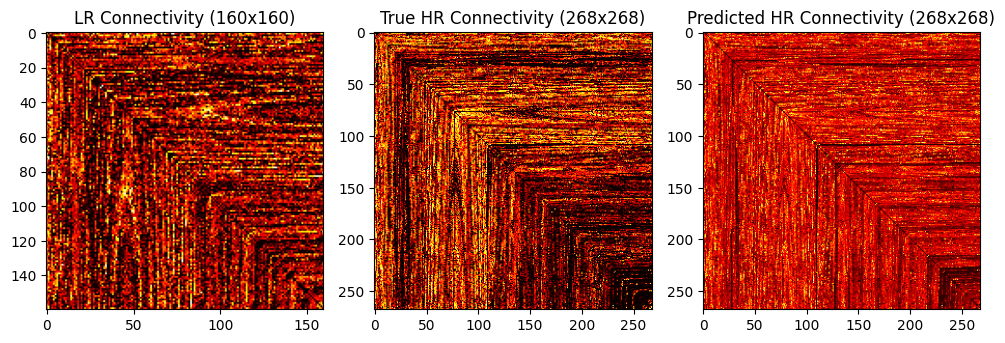

In [22]:
# Visualization
sample_idx = 0  # Changed to match test data
lr_adj = vector_to_adj_matrix(test_LR[sample_idx], 160)
pred_hr = np.zeros((268, 268))
triu_indices = np.triu_indices(268, k=1)
pred_hr[triu_indices] = test_predictions[sample_idx]
pred_hr = pred_hr + pred_hr.T
hr_adj = vector_to_adj_matrix(train_HR[sample_idx], 268)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("LR Connectivity (160x160)")
plt.imshow(lr_adj, cmap='hot')
plt.subplot(1, 3, 2)
plt.title("True HR Connectivity (268x268)")
plt.imshow(hr_adj, cmap='hot')
plt.subplot(1, 3, 3)
plt.title("Predicted HR Connectivity (268x268)")
plt.imshow(pred_hr, cmap='hot')
plt.tight_layout()
plt.show()

In [25]:
torch.save(model.state_dict(), '/content/drive/MyDrive/brain_connectivity_graphunet.pth')